In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.linear_model import LinearRegression

In [2]:
companies = pd.read_csv("companies_rated.csv")

In [3]:
companies

,company_id,region,country,exchange,industry,company_name,ticker,trading_status
0,4455588,Africa / Middle East,Bahrain,BAX,Banks,Bank of Bahrain and Kuwait B.S.C.,BBK,Active
1,883038,Africa / Middle East,Egypt,CASE,Banks,Commercial International Bank (Egypt) S.A.E,COMI,Active
2,2472872,Africa / Middle East,Egypt,CASE,Capital Markets,EFG-Hermes Holding S.A.E,HRHO,Active
3,46263794,Africa / Middle East,Egypt,CASE,Capital Markets,Pioneers Holding Company For Financial Investm...,PIOH,Active
4,32339123,Africa / Middle East,Egypt,CASE,Capital Markets,Qalaa Holdings S.A.E.,CCAP,Active
...,...,...,...,...,...,...,...,...
7818,93339,United States and Canada,United States,NasdaqGS,Wireless Telecommunication Services,"T-Mobile US, Inc.",TMUS,Active
7819,379316,United States and Canada,United States,NasdaqGS,Wireless Telecommunication Services,VEON Ltd.,VEON,Active
7820,13757558,United States and Canada,United States,OTCPK,IT Services,"GTT Communications, Inc.",GTTN,Active
7821,874816,United States and Canada,United States,OTCPK,Media,Axel Springer SE,AXEL.F,Active


## Analisando a frequência de cada setor no dataset

<AxesSubplot:>

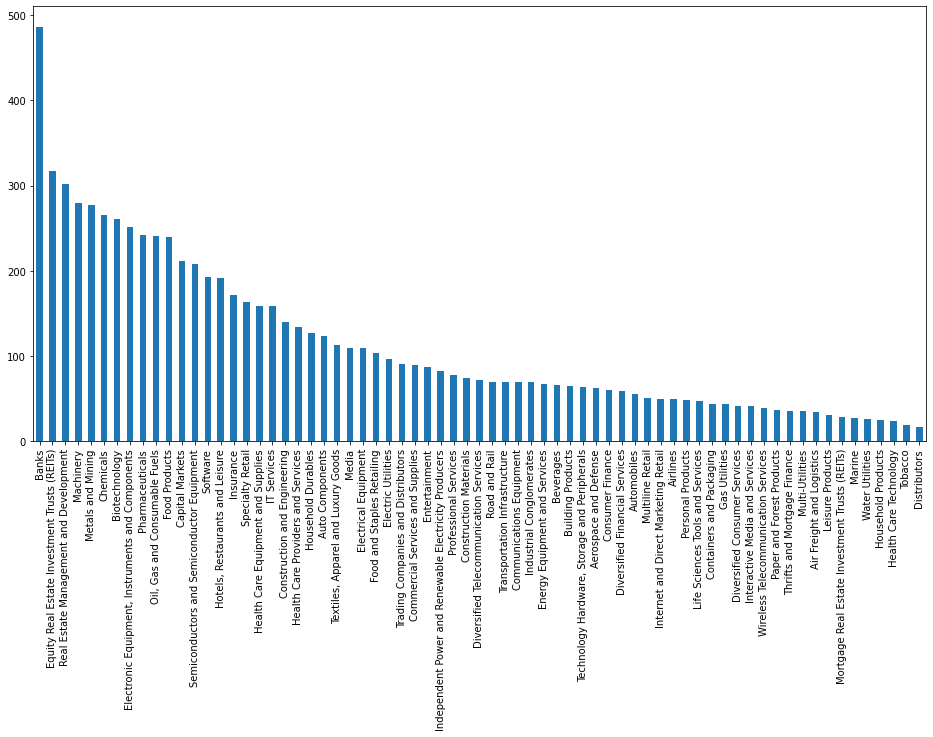

In [4]:
plt.figure(figsize=(16,8))
companies["industry"].value_counts().plot(kind='bar')

In [5]:
companies["industry"].nunique()

69

### Percebemos que tem uma desigualdade na quantidade de empresas por setor, o que poderia criar um viés nos modelos de clusterização

## Analisando o ESG

In [6]:
esg_data = pd.read_csv("esg_scores_history_rated.csv")

In [7]:
esg_data["assessment_year"] = pd.to_datetime(esg_data["assessment_year"],format="%Y")
esg_data.fillna(0,inplace=True)

In [8]:
dimensions = esg_data["parent_aspect"].unique()
dimensions

array(['Environmental Dimension', 'Governance & Economic Dimension',
       'S&P Global ESG Score', 'Social Dimension', 0], dtype=object)

In [30]:
esg_data

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
0,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Policy & Management Systems,8,43.400000
1,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Reporting,7,40.250000
2,2013-01-01,AIR Airlines,31726,Environmental Dimension,Operational Eco-Efficiency,11,32.400000
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
...,...,...,...,...,...,...,...
844373,2020-01-01,TSV IT services,584499446,Social Dimension,Human Rights,3,0.000000
844374,2020-01-01,TSV IT services,584499446,Social Dimension,Labor Practice Indicators,4,7.200000
844375,2020-01-01,TSV IT services,584499446,Social Dimension,Social Reporting,4,0.000000
844376,2020-01-01,TSV IT services,584499446,Social Dimension,Talent Attraction & Retention,7,25.000000


## Analisando como se comporta a distribuição dos scores por dimensão Ambiental, Governança, Social e do Global ESG 

<AxesSubplot:xlabel='parent_aspect', ylabel='score_value'>

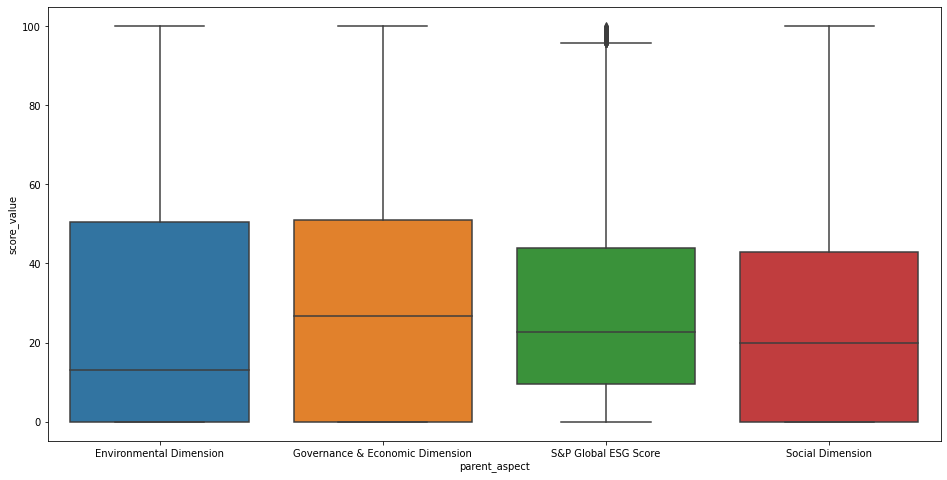

In [35]:
plt.figure(figsize=(16,8))
sns.boxplot(x="parent_aspect",y="score_value",data=esg_data[esg_data["parent_aspect"] != 0])

### Vemos que a distribuição aparenta ser similar, embora para a questão ambiental a mediana parece estar mais afastada das demais. Isso é um possível indicativo de que a questão ambiental ainda não é uma preocupação das empresas

# Vamos agora construir um modelo tal que, com base nas observações passadas, consiga predizer o score de cada uma das componentes do ESG

In [10]:
## FUNCAO QUE DADO UM DATAFRAME FAZ A MEDIA PONDERADA
def singleSum(df):
    total = 0
    denom = 0
    for i,row in df.iterrows():
        w = row["score_weight"]
        if row["score_value"] != np.nan:
            total += row["score_value"]*w
        denom += w
    return total/denom

#### Pequeno teste

In [11]:
dimensions_weights = {}
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
s = esg_data[mask].groupby("assessment_year").apply(singleSum)

In [12]:
s

assessment_year
2013-01-01    44.491053
2014-01-01    47.705467
2015-01-01    44.098280
2016-01-01    40.533114
2017-01-01    46.407925
2018-01-01    32.640737
2019-01-01    32.846734
2020-01-01    36.674379
dtype: float64

In [13]:
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


In [14]:
esg_data[esg_data["parent_aspect"].isna()]["aspect"].unique()

array([], dtype=object)

In [15]:
esg_data[mask]["score_value"].isnull().sum()

0

In [16]:
def fillSeries(df):
    idx = pd.period_range(start=df.index.min(),end=df.index.max(),freq="A")
    df = df.reindex(idx, fill_value=np.nan)
    return df.interpolate()

def makeSeries(df):
    df = df.sort_values(by="Environmental Dimension")
    s = df.set_index("Environmental Dimension")["assessment_year"]
    s = s.to_period('A')
    s = fillSeries(s)
    return s

In [17]:
## FUNCAO QUE COMPUTA O SCORE DE UMA DADA EMPRESA, NUMA DADA DIMENSÃO, E FAZ A PREVISÃO DO SCORE
def computeScore(dimension,company_id,esg_data):
    if dimension == 'S&P Global ESG Score':
        type_ = "aspect"
    else:
        type_ = "parent_aspect"
    mask = (esg_data[type_] == dimension) & (esg_data["company_id"] == company_id)
    s = esg_data[mask].groupby("assessment_year").apply(singleSum)
#     s = fillSeries(s)
    future_score = 0
    len_s = len(s)
    #O ExponentialSmoothing nao consegue fazer fit com menos de 10 pontos
    if len_s > 10:
        model = ExponentialSmoothing(s)
        model.fit()
        future_score = model.predict(model.params)
    else:
        reg = 0
        try:
            reg = LinearRegression().fit(np.arange(len_s).reshape(-1, 1),s)
        except:
            print(s,company_id)
        #print(s,np.arange(len_s).reshape(-1, 1),company_id)
        future_score = reg.predict(np.array([len_s]).reshape(-1, 1))
    return future_score[0]

In [18]:
def computeScores(company_id,esg_data):
    future_scores = {}
    dims = esg_data["parent_aspect"].unique()[:4]
    for dimension in dims:
        future_scores[dimension] = computeScore(dimension,company_id,esg_data)
    return future_scores

#### Pequeno teste

In [19]:
computeScores(31726,esg_data)

{'Environmental Dimension': 55.345087697121365,
 'Governance & Economic Dimension': 32.23677131171603,
 'S&P Global ESG Score': 35.13945971428572,
 'Social Dimension': 24.830252456114863}

In [20]:
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


## Para prova de conceito, vamos fazer uma amostragem de alguns setores e efetuar os cálculos para ela

In [21]:
# sectors = companies["industry"].unique()
sectors = ['Oil, Gas and Consumable Fuels','Metals and Mining','Road and Rail','Textiles, Apparel and Luxury Goods']
# min_sector_freq = companies["industry"].value_counts().min()
min_sector_freq = 5
sample = companies[companies["industry"].isin(sectors)].groupby('industry').apply(lambda s: s.sample(min_sector_freq))[["company_id","industry"]]
sample

company_id  \
industry                                              
Metals and Mining                  6444      392824   
                                   5513    79692237   
                                   544       191781   
                                   550      7688428   
                                   5525    39417218   
Oil, Gas and Consumable Fuels      598       873963   
                                   2878    10175792   
                                   4242      880478   
                                   2508     5490756   
                                   1799      882940   
Road and Rail                      5608      353020   
                                   2595      877581   
                                   2600      875638   
                                   2580      882414   
                                   2585      879800   
Textiles, Apparel and Luxury Goods 4222       92816   
                                   4787      875547   
                                   3720   132841672   
                                   1496    37349460   
                                   6708      330762   

                                                                   industry  
industry                                                                     
Metals and Mining                  6444                   Metals and Mining  
                                   5513                   Metals and Mining  
                                   544                    Metals and Mining  
                                   550                    Metals and Mining  
                                   5525                   Metals and Mining  
Oil, Gas and Consumable Fuels      598        Oil, Gas and Consumable Fuels  
                                   2878       Oil, Gas and Consumable Fuels  
                                   4242       Oil, Gas and Consumable Fuels  
                                   2508       Oil, Gas and Consumable Fuels  
                                   1799       Oil, Gas and Consumable Fuels  
Road and Rail                      5608                       Road and Rail  
                                   2595                       Road and Rail  
                                   2600                       Road and Rail  
                                   2580                       Road and Rail  
                                   2585                       Road and Rail  
Textiles, Apparel and Luxury Goods 4222  Textiles, Apparel and Luxury Goods  
                                   4787  Textiles, Apparel and Luxury Goods  
                                   3720  Textiles, Apparel and Luxury Goods  
                                   1496  Textiles, Apparel and Luxury Goods  
                                   6708  Textiles, Apparel and Luxury Goods

### Computa os escores do ESG e salva num dataframe

In [23]:
ids = sample["company_id"]
scores_df = []
for id_ in ids:
    data=computeScores(id_,esg_data)
    data["company_id"] = np.int64(id_)
    scores_df.append(data)

In [24]:
scores_df = pd.DataFrame(scores_df).fillna(0)
scores_df

,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension,company_id
0,23.862124,33.433484,32.414865,36.605850,392824
1,0.650000,17.997576,7.271200,3.211429,79692237
2,24.592615,27.951924,23.940235,20.299354,191781
3,1.825000,15.380504,6.792900,1.942857,7688428
4,19.113901,40.404721,35.335685,1.453123,39417218
5,74.611055,77.238782,76.879597,77.623621,873963
6,6.398161,24.279939,11.902812,3.097893,10175792
7,78.166617,67.044682,70.585090,69.014499,880478
8,7.759312,0.168429,3.352728,2.993517,5490756
9,23.636352,11.526102,14.107510,8.991741,882940


### Junta os scores com outros dados da empresa

In [25]:
sample = sample.merge(scores_df,left_on="company_id",right_on="company_id")
sample

,company_id,industry,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension
0,392824,Metals and Mining,23.862124,33.433484,32.414865,36.605850
1,79692237,Metals and Mining,0.650000,17.997576,7.271200,3.211429
2,191781,Metals and Mining,24.592615,27.951924,23.940235,20.299354
3,7688428,Metals and Mining,1.825000,15.380504,6.792900,1.942857
4,39417218,Metals and Mining,19.113901,40.404721,35.335685,1.453123
5,873963,"Oil, Gas and Consumable Fuels",74.611055,77.238782,76.879597,77.623621
6,10175792,"Oil, Gas and Consumable Fuels",6.398161,24.279939,11.902812,3.097893
7,880478,"Oil, Gas and Consumable Fuels",78.166617,67.044682,70.585090,69.014499
8,5490756,"Oil, Gas and Consumable Fuels",7.759312,0.168429,3.352728,2.993517
9,882940,"Oil, Gas and Consumable Fuels",23.636352,11.526102,14.107510,8.991741


### Exporta para um csv, para que possamos a continuar o protótipo em outra vertente

In [26]:
sample.to_csv("Amostra_das_empresas.csv")